## Fine tuning data preparation

* In the DNABERT
    * Their data for pretrain (`6_3k.txt`) didn't really have common sequence with their fine tuning data.
    * There are two fine tuning training data: `train.tsv` (21Mb) and `dev.tsv` (660K)
    * Those data are labelled (delimited by tab) into 2 classes, 0 or 1.


In [2]:
from css_utility import *
import seaborn as sns
import random
from motif_utils import kmer2seq
import pickle
from tqdm import tqdm_notebook

In [64]:
# For saving gene expression fine-tuning data
def prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=20000, len_dev=1000):
    """
    * Generallized function for preparing fine tuning data.
    * cl1 and cl2 refer to the name of class you want to classify in binary classification.
    * This function considers the path for cl1 and cl2 are under the input path.
    * cl1 and cl2 are any of "expressed", "highly_expressed", "not_expressed" 
    * epi_num_lst should contain the name of epigenomes like "E003"
    """
    print("* Input path: ", input_path)
    print("* Binary classification for '{}' and '{}'".format(cl1, cl2))
    print("* Output path: ", output_path)
    print("* Cut threshold length: ", cut_thres)
    print("* k-merization: ", k)
    print("* train: dev = {} : {}".format(len_tr,len_dev))
    
    cl1_path=input_path+cl1+"/"
    cl2_path=input_path+cl2+"/"
    
    cl1_concat=[]
    cl2_concat=[]
    
    suffix_dict = {}
    for cl in [cl1, cl2]:
        if "highly" in cl:
            suffix_dict[cl] = "_highly_exp_gene_css.pkl"
        elif "not" in cl:
            suffix_dict[cl] = "_not_exp_gene_css.pkl"
        else:
            suffix_dict[cl] = "_exp_gene_css.pkl"
    
    for cl, concat_lst in [(cl1, cl1_concat), (cl2, cl2_concat)]:
        for epi_num in epi_num_lst:
            file_path = input_path + cl + "/" + epi_num + suffix_dict[cl]
            concat_lst.extend(pickle.load(open(file_path, "rb")))
    
    # kmerization
    _, cl1_kmerized=css_CUT_Kmer(cl1_concat, cut_thres, k)
    _, cl2_kmerized=css_CUT_Kmer(cl2_concat, cut_thres, k)
    
    # make it dataframe
    df_cl1=pd.DataFrame(cl1_kmerized, columns=["sequence"])
    df_cl1["label"]=1
    df_cl2=pd.DataFrame(cl2_kmerized, columns=["sequence"])
    df_cl2["label"]=0
    
    # make them have the same length
    if len(df_cl1)>len(df_cl2):
        df_cl1=df_cl1[:len(df_cl2)] 
    elif len(df_cl1)<len(df_cl2):
        df_cl2=df_cl2[:len(df_cl1)]
    assert len(df_cl1)==len(df_cl2), "Check the data length."
    
    # shuffling ...
    df_all=pd.concat([df_cl1,df_cl2]).sample(frac=1).reset_index(drop=True)  

    # cutting into train and dev
    assert len(df_all)> len_tr+len_dev, "Not enough data length."
    df_train=df_all[:len_tr]
    df_dev=df_all[len_tr:len_tr+len_dev]    
  
    #path="../database/fine_tune/"+save_path+"/"+str(k)+"mer/"
    train_name=output_path+"train.tsv"
    dev_name=output_path+"dev.tsv"
    
    df_train.to_csv(train_name, sep="\t", index=False)
    df_dev.to_csv(dev_name, sep="\t", index=False)

    return print("Fine-tuning data for {} and {} (epigenome no. {}) are {}merized and saved at {}.".format(cl1, cl2, epi_num_lst, k, output_path))

In [67]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/Gexp_or_not/4mer/"
cl1="expressed"
cl2="not_expressed"
epi_num_lst=["E003","E128"]

In [68]:
prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=20000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/Gexp_or_not/4mer/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 20000 : 1000
Fine-tuning data for expressed and not_expressed (epigenome no. ['E003', 'E128']) are 4merized and saved at ../database/fine_tune/Gexp_or_not/4mer/.


In [73]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/Ghexp_or_exp/4mer/"
cl1="highly_expressed"
cl2="expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

In [74]:
prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=20000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'highly_expressed' and 'expressed'
* Output path:  ../database/fine_tune/Ghexp_or_exp/4mer/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 20000 : 1000
Fine-tuning data for highly_expressed and expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/Ghexp_or_exp/4mer/.


In [77]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/Ghexp_or_not/4mer/"
cl1="highly_expressed"
cl2="not_expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

In [78]:
prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=20000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'highly_expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/Ghexp_or_not/4mer/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 20000 : 1000
Fine-tuning data for highly_expressed and not_expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/Ghexp_or_not/4mer/.


In [90]:
#### doubling the datset.. to make the train set 40k long (for hexp - not)
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/Ghexp_or_not/4mer/tr_len_40k/"
cl1="highly_expressed"
cl2="not_expressed"
# epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
file_lst=os.listdir("../database/temp_files/expressed/byCellType/expressed/")
file_lst.sort()
epi_num_lst=[elm[:4] for elm in file_lst]

In [91]:
prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'highly_expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/Ghexp_or_not/4mer/tr_len_40k/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for highly_expressed and not_expressed (epigenome no. ['E003', 'E004', 'E005', 'E006', 'E007', 'E011', 'E012', 'E013', 'E016', 'E024', 'E027', 'E028', 'E037', 'E038', 'E047', 'E050', 'E053', 'E054', 'E055', 'E056', 'E057', 'E058', 'E059', 'E061', 'E062', 'E065', 'E066', 'E070', 'E071', 'E079', 'E082', 'E084', 'E085', 'E087', 'E094', 'E095', 'E096', 'E097', 'E098', 'E100', 'E104', 'E105', 'E106', 'E109', 'E112', 'E113', 'E114', 'E116', 'E117', 'E118', 'E119', 'E120', 'E122', 'E123', 'E127', 'E128']) are 4merized and saved at ../database/fine_tune/Ghexp_or_not/4mer/tr_len_40k/.


In [92]:
#### doubling the datset.. to make the train set 40k long (for hexp - exp)
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/Ghexp_or_exp/4mer/tr_len_40k/"
cl1="highly_expressed"
cl2="expressed"
# epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
file_lst=os.listdir("../database/temp_files/expressed/byCellType/expressed/")
file_lst.sort()
epi_num_lst=[elm[:4] for elm in file_lst]

In [93]:
prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'highly_expressed' and 'expressed'
* Output path:  ../database/fine_tune/Ghexp_or_exp/4mer/tr_len_40k/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for highly_expressed and expressed (epigenome no. ['E003', 'E004', 'E005', 'E006', 'E007', 'E011', 'E012', 'E013', 'E016', 'E024', 'E027', 'E028', 'E037', 'E038', 'E047', 'E050', 'E053', 'E054', 'E055', 'E056', 'E057', 'E058', 'E059', 'E061', 'E062', 'E065', 'E066', 'E070', 'E071', 'E079', 'E082', 'E084', 'E085', 'E087', 'E094', 'E095', 'E096', 'E097', 'E098', 'E100', 'E104', 'E105', 'E106', 'E109', 'E112', 'E113', 'E114', 'E116', 'E117', 'E118', 'E119', 'E120', 'E122', 'E123', 'E127', 'E128']) are 4merized and saved at ../database/fine_tune/Ghexp_or_exp/4mer/tr_len_40k/.


In [94]:
#### doubling the datset.. to make the train set 40k long (for exp - not)
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/Gexp_or_not/4mer/tr_len_40k/"
cl1="expressed"
cl2="not_expressed"
# epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
file_lst=os.listdir("../database/temp_files/expressed/byCellType/expressed/")
file_lst.sort()
epi_num_lst=[elm[:4] for elm in file_lst] # epi_num is all epigenome data

In [95]:
prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/Gexp_or_not/4mer/tr_len_40k/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for expressed and not_expressed (epigenome no. ['E003', 'E004', 'E005', 'E006', 'E007', 'E011', 'E012', 'E013', 'E016', 'E024', 'E027', 'E028', 'E037', 'E038', 'E047', 'E050', 'E053', 'E054', 'E055', 'E056', 'E057', 'E058', 'E059', 'E061', 'E062', 'E065', 'E066', 'E070', 'E071', 'E079', 'E082', 'E084', 'E085', 'E087', 'E094', 'E095', 'E096', 'E097', 'E098', 'E100', 'E104', 'E105', 'E106', 'E109', 'E112', 'E113', 'E114', 'E116', 'E117', 'E118', 'E119', 'E120', 'E122', 'E123', 'E127', 'E128']) are 4merized and saved at ../database/fine_tune/Gexp_or_not/4mer/tr_len_40k/.


In [102]:
#### doubling the datset.. to make the train set 40k long (for exp - not)
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/Gexp_or_not/4mer/tr_len_40k_test/"
cl1="expressed"
cl2="not_expressed"
# epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
file_lst=os.listdir("../database/temp_files/expressed/byCellType/expressed/")
file_lst.sort()
epi_num_lst=["E003","E128"]
# epi_num_lst=[elm[:4] for elm in file_lst] # epi_num is all epigenome data

In [103]:
prep_and_saveTF(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/Gexp_or_not/4mer/tr_len_40k_test/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for expressed and not_expressed (epigenome no. ['E003', 'E128']) are 4merized and saved at ../database/fine_tune/Gexp_or_not/4mer/tr_len_40k_test/.


In [112]:
path="../database/temp_files/expressed/byCellType/expressed/"
print(path+sorted(os.listdir(path))[0])

../database/temp_files/expressed/byCellType/expressed/E003_exp_gene_css.pkl


In [104]:
with open("../database/temp_files/expressed/byCellType/expressed/E003_exp_gene_css.pkl", "rb") as f:
    test=pickle.load(f)

In [113]:
test[0]

'KLLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMLLLLLMMMMMMMLLLKLLMMMMMMMMMMMMMLLLLLLKJJKLKKKKJJJKKKKLLLLEEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEEEEEE'

In [149]:
path="../database/temp_files/whole_gene_unit/E128_css_gene_unit_lst_all.pkl"
path[-4:]

'.pkl'

In [176]:
pkl_path="../database/temp_files/whole_gene_unit/"
pkl_files = sorted([f for f in os.listdir(pkl_path) if f.endswith('.pkl')])
css_concat=[]
# for file in pkl_files:
#     with open(pkl_path+file,"rb") as f:
#         css=pickle.load(f)

In [177]:
pkl_path+pkl_files[0]

'../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl'

In [220]:
css_concat=[]
for i in range(3):
    with open(pkl_path+pkl_files[i],"rb") as f:
        css=pickle.load(f)
        css_flat=flatLst(css)
        print("{}th iteration: epi {}, length of css_flat ".format(i,pkl_files[i], len(css_flat)))
        css_concat.extend(css_flat)
        print("len(css_concat)",len(css_concat))
print("total len(css_concat)",len(css_concat))

0th iteration: epi E003_css_gene_unit_lst_all.pkl, length of css_flat 
len(css_concat) 43489
1th iteration: epi E004_css_gene_unit_lst_all.pkl, length of css_flat 
len(css_concat) 83993
2th iteration: epi E005_css_gene_unit_lst_all.pkl, length of css_flat 
len(css_concat) 128180
total len(css_concat) 128180


In [222]:
css_concat = []

for pkl_file in pkl_files:
    with open(pkl_path + pkl_file, "rb") as f:
        css = pickle.load(f)
        if isinstance(css[0], list):
            css_flat = flatLst(css)
            css_concat.extend(css_flat)
        else:
            css_concat.extend(css)
            
print("Total length of css_concat:", len(css_concat))


Total length of css_concat: 2403712


In [218]:
css_concat=[]
for i in range(3):
    with open(pkl_path+pkl_files[i],"rb") as f:
        css=pickle.load(f)
#     if type(css[0])=="list":
#         css_flat=flatLst(css)
#         print("{}th iteration: epi {}, length of css_flat:{} ".format(i,pkl_files[i], len(css_flat)))
#         css_concat.extend(css_flat)
#     else:
        css_concat.extend(css)
        print("len(css_concat)",len(css_concat))
        if type(css_concat[0])=="list":
            css_concat=flatLst(css_concat)
        
print("total len(css_concat)",len(css_concat))

len(css_concat) 24
len(css_concat) 48
len(css_concat) 72
total len(css_concat) 72


In [208]:
128180-127482

698

In [179]:
with open(pkl_path+pkl_files[0],"rb") as f:
    css=pickle.load(f)
    css_flat=flatLst(css)
    

24

In [185]:
css_flat=flatLst(css)

In [187]:
len(css_flat)

43489

In [ ]:
for i in range(3):

In [3]:
#Generalized version, for splitted (the result of css_CUT_Kmer) or from the pkl file saved 
# e.g.) css_composition_piechart_Gen(load_pkl=True, pkl_path="../database/temp_files/expressed/byCellType/highly_expressed/",show_pct=5, title="highly_expressed")
def css_composition_piechart_Gen(load_pkl=True, pkl_path=None, splitted=None, show_pct=5, **kwargs):
    """
    Usage: css_composition_piechart using the data from either .pkl or splitted (after running css_CUT_Kmer)
    Input: .pkl file path or2for , splitted_lst can be the first production of the function "css_CUT_Kmer"
    show_pct: threshold to show the percentage in pie chart
    """
    ### case 1. when you load .pkl which is usually stored at ../database/temp_files
    if load_pkl:
        if pkl_path is None:
            raise ValueError("Path for the folder including .pkl files is required if load_pkl is True.")
        else:
            pkl_files = sorted([f for f in os.listdir(pkl_path) if f.endswith('.pkl')])
            css_concat=[]
            for pkl_file in pkl_files:
                with open(pkl_path + pkl_file, "rb") as f:
                    css = pickle.load(f)
                    if isinstance(css[0], list):
                        css_flat = flatLst(css)
                        css_concat.extend(css_flat)
                    else:
                        css_concat.extend(css)
        splitted=css_concat

    ### case 2. when you use splitted, the first one of the results from the function css_CUT_kmer
    else:
        if splitted is None:
            raise ValueError("Splitted is required. Run the css_CUT_Kmer first.")
    
    splitted_lst=splitted
    num_elm=len(splitted_lst)
    print("total {} of fragments.".format(num_elm))
    
    state_count = {chr(i): 0 for i in range(ord('A'), ord('O')+1)}
    for elm in splitted_lst:
        for state in elm:
            if state in state_count:
                state_count[state] += 1  # create a dictionary, value of which is the no. of state appeared overall
    total = sum(state_count.values())
    sizes = [i/sum(state_count.values())*100 for i in state_count.values()] # percentage of occupation
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 6))

    ax1.pie(state_count.values(),colors=[state_col_dict[label] for label in state_count.keys()], autopct=lambda p: '{:.2f}%'.format(p) if p > show_pct else '')

    if "title" in kwargs:
        ax1.set_title(kwargs["title"], fontsize=15)
    
    for t in ax1.texts:
        t.set_color("white")
        t.set_fontsize(15)
        
    # print the list of percentages and states
    # uncomment this if you want to use text rather than picture-table
#     for state, size in zip(state_count.keys(), sizes):
#         num_states = int(round(size * total / 100))
#         print(f"{state}. {num_states} ({size:.2f}%)")

    # Hide axis
    ax2.axis('off')

    # Create table
    table = ax2.table(cellText=list(zip(state_count.keys(), [f"{size:.2f}" for size in sizes])),
                     colLabels=['State', 'Proportion'],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(0.5, 1)
    
    
    plt.show()
    


total 66357 of fragments.


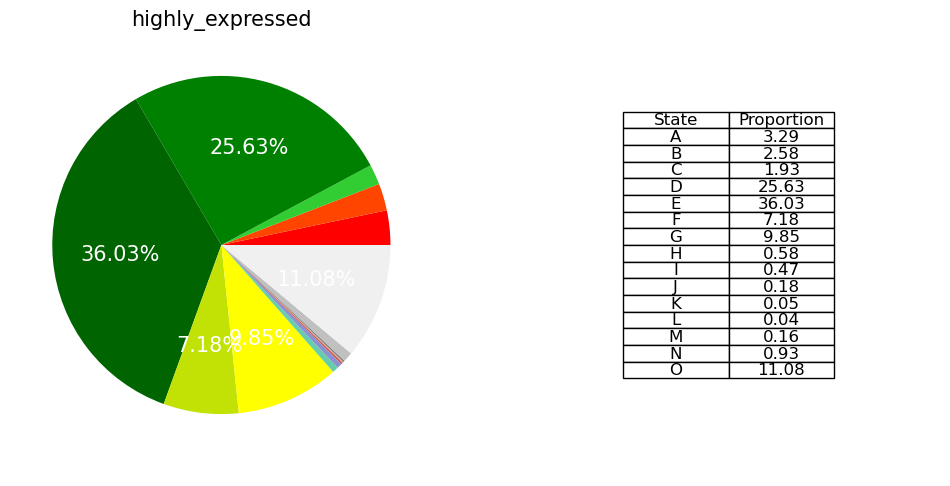

In [4]:
css_composition_piechart_Gen(load_pkl=True, pkl_path="../database/temp_files/expressed/byCellType/highly_expressed/",show_pct=5, title="highly_expressed")

total 2403712 of fragments.


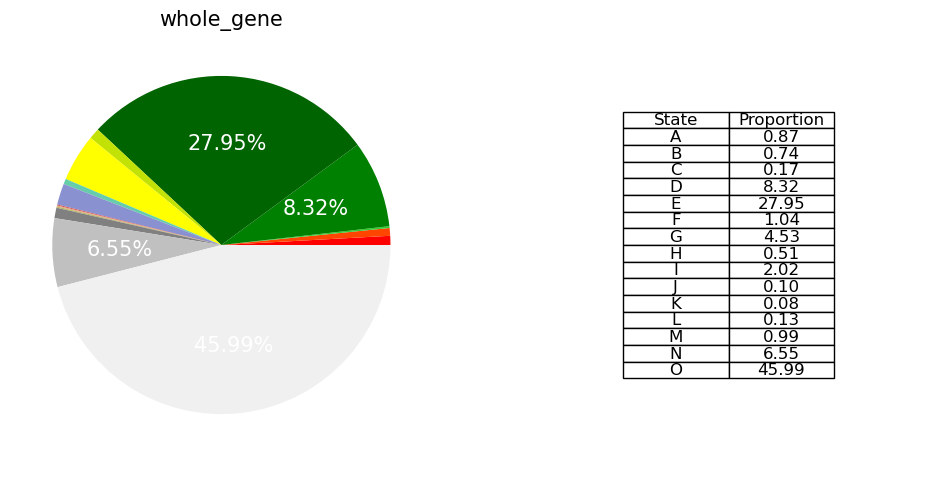

In [5]:
css_composition_piechart_Gen(load_pkl=True, pkl_path="../database/temp_files/whole_gene_unit/",show_pct=5, title="whole_gene")

total 741210 of fragments.


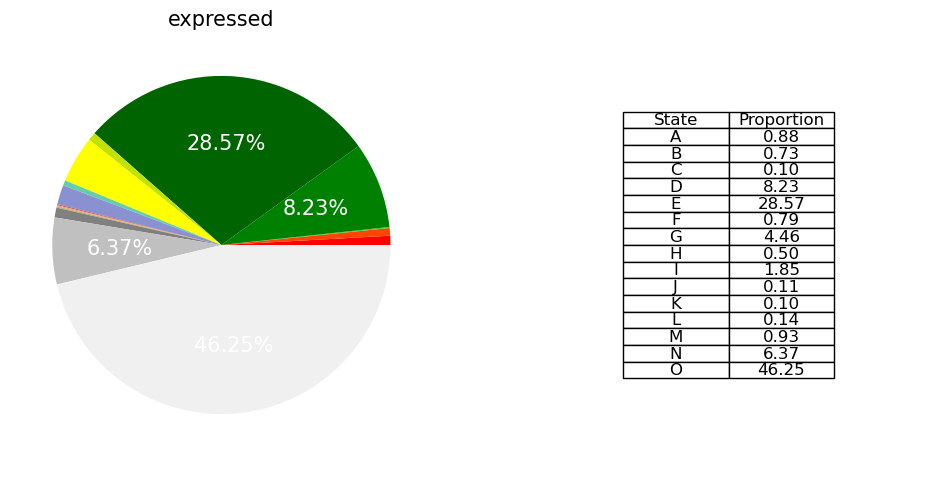

In [6]:
css_composition_piechart_Gen(load_pkl=True, pkl_path="../database/temp_files/expressed/byCellType/expressed/",show_pct=5, title="expressed")

total 1395450 of fragments.


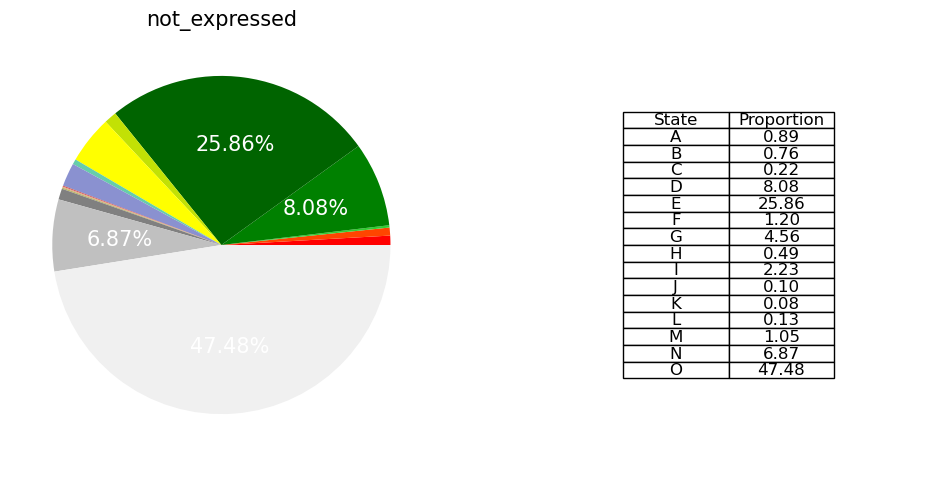

In [7]:
css_composition_piechart_Gen(load_pkl=True, pkl_path="../database/temp_files/expressed/byCellType/not_expressed/",show_pct=5, title="not_expressed")

In [3]:
exp=pickle.load(open("../database/temp_files/expressed/byCellType/expressed/E004_exp_gene_css.pkl","rb"))

In [4]:
_, exp_kmerized=css_CUT_Kmer(exp, 510, 4)

In [6]:
df_exp=pd.DataFrame(exp_kmerized, columns=["sequence"])

In [8]:
len(df_exp)

18175

In [7]:
df_exp.head()

,sequence
0,JJJL JJLM JLMM LMMM MMMM MMMM MMMM MMMM MMMN M...
1,AAAA AAAK AAKM
2,JJMM JMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM M...
3,NNNN NNNN NNNA NNAA
4,AAGG


In [2]:
comp=pickle.load(open("../database/temp_files/complexity/thres_mean/comp", "rb"))

In [3]:
less_comp=pickle.load(open("../database/temp_files/complexity/thres_mean/less_comp", "rb"))

In [5]:
_, comp_kmerized=css_CUT_Kmer(comp, 510, 4)
_, less_comp_kmerized=css_CUT_Kmer(less_comp, 510, 4)

In [6]:
df_comp=pd.DataFrame(comp_kmerized, columns=["sequence"])
df_comp["label"]=1
df_comp

,sequence,label
0,MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM M...,1
1,MNNE NNEE NEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,1
2,JJJJ JJJJ JJJJ JJJM JJMM JMMM MMMN MMNN MNNN N...,1
3,MMMJ MMJJ MJJJ JJJM JJMN JMNN MNNN NNNN NNNN N...,1
4,MMMJ MMJJ MJJJ JJJM JJMN JMNN MNNN NNNN NNNN N...,1
...,...,...
12998,EEEE EEEE EEED EEDD EDDD DDDC DDCC,1
12999,EEEE EEEE EEED EEDD EDDD DDDC DDCC,1
13000,EEEE EEEE EEED EEDD EDDD DDDC DDCC,1
13001,EEEE EEEE EEED EEDD EDDD,1


In [7]:
df_less_comp=pd.DataFrame(less_comp_kmerized, columns=["sequence"])
df_less_comp["label"]=0
df_less_comp

,sequence,label
0,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
1,AOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
2,AOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
3,AOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
4,AOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
...,...,...
43777,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
43778,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
43779,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
43780,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0


In [30]:
df_comp_all=pd.concat([df_comp,df_less_comp]).sample(frac=1).reset_index(drop=True) 

In [35]:
df_comp_all

,sequence,label
0,AAAA AAAA AAAA AAAB AABG ABGG BGGG GGGB GGBB G...,1
1,EEGE EGEE GEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,0
2,GGGG,1
3,JJJJ JJJL JJLM JLMM LMMM MMMM MMMN MMNN MNNN N...,1
4,AAAA AAAA AAAA AAAA AAAE,1
...,...,...
26001,EEEE EEEE EEEE EEEE EEEE,1
26002,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
26003,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,1
26004,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0


In [8]:
if len(df_comp)>len(df_less_comp):
        df_comp=df_comp[:len(df_less_comp)] 
elif len(df_comp)<len(df_less_comp):
        df_less_comp=df_less_comp[:len(df_comp)]
assert len(df_comp)==len(df_less_comp)

In [9]:
df_comp_all=pd.concat([df_comp,df_less_comp]).sample(frac=1).reset_index(drop=True)  
df_comp_all[100:110]

,sequence,label
100,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
101,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
102,AAAA AAAA AAAA,1
103,NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN N...,1
104,EEEE EEEE EEEE EEEE,1
105,IIHH IHHH HHHH HHHH HHHI HHII HIII IIII IIII I...,0
106,AAAA AAAA AAAA AAAB AABB ABBG BBGG BGGE GGEE G...,1
107,EEEE EEED EEDD EDDD DDDD DDDD DDDE DDEE DEEE E...,0
108,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
109,EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEED E...,0


In [57]:
# now for compG and nonCompG (the function covers from prepration to save)
def prep_and_saveTF_CompNcomp(condition="thres_mean", cut_thres=510, k=5, save_path="CompG_and_lessCompG",len_tr=20000, len_dev=1000):
    """
    prepare fine tuning data for [the complex gene css / less complex gene css]
    """
    print("* Project name: ", save_path)
    print("* condition: ", condition)
    print("* Cut threshold length: ", cut_thres)
    print("* k-merization: ", k)
    print("* train: dev = {} : {}".format(len_tr,len_dev))
    
    comp_path="../database/temp_files/complexity/"+condition+"/comp"
    comp=pickle.load(open(comp_path, "rb"))
    less_comp_path="../database/temp_files/complexity/"+condition+"/less_comp"
    less_comp=pickle.load(open(less_comp_path, "rb"))
    
    # kmerization
    _, comp_kmerized=css_CUT_Kmer(comp, cut_thres, k)
    _, less_comp_kmerized=css_CUT_Kmer(less_comp, cut_thres, k)
    
    # make it dataframe
    df_comp=pd.DataFrame(comp_kmerized, columns=["sequence"])
    df_comp["label"]=1
    df_less_comp=pd.DataFrame(less_comp_kmerized, columns=["sequence"])
    df_less_comp["label"]=0
    
    # make them have the same length
    if len(df_comp)>len(df_less_comp):
        df_comp=df_comp[:len(df_less_comp)] 
    elif len(df_comp)<len(df_less_comp):
        df_less_comp=df_less_comp[:len(df_comp)]
    assert len(df_comp)==len(df_less_comp), "Check the data length."
    
    # shuffling ...
    df_comp_all=pd.concat([df_comp,df_less_comp]).sample(frac=1).reset_index(drop=True)  

    # cutting into train and dev
    assert len(df_comp_all)> len_tr+len_dev, "Not enough data length."
    df_comp_train=df_comp_all[:len_tr]
    df_comp_dev=df_comp_all[len_tr:len_tr+len_dev]    
  
    path="../database/fine_tune/"+save_path+"/"+str(k)+"mer/"
    train_name=path+"train.tsv"
    dev_name=path+"dev.tsv"
    
    df_comp_train.to_csv(train_name, sep="\t", index=False)
    df_comp_dev.to_csv(dev_name, sep="\t", index=False)

    return print("Fine-tuning data for {} are {}merized and saved at {}.".format(save_path,k,path))

In [37]:
prep_and_saveTF_CompNcomp(condition="thres_mean", cut_thres=510, k=5, save_path="CompG_and_lessCompG",len_tr=20000, len_dev=1000)

* Project name:  CompG_and_lessCompG
* condition:  thres_mean
* Cut threshold length:  510
* k-merization:  5
* train: dev = 20000 : 1000
Fine-tuning data for CompG_and_lessCompG are 5merized and saved at ../database/fine_tune/CompG_and_lessCompG/5mer/.


In [38]:
prep_and_saveTF_CompNcomp(condition="thres_mean", cut_thres=510, k=4, save_path="CompG_and_lessCompG",len_tr=20000, len_dev=1000)

* Project name:  CompG_and_lessCompG
* condition:  thres_mean
* Cut threshold length:  510
* k-merization:  4
* train: dev = 20000 : 1000
Fine-tuning data for CompG_and_lessCompG are 4merized and saved at ../database/fine_tune/CompG_and_lessCompG/4mer/.


In [58]:
# now,  for compG and non gene (the function covers from prepration to save)
def prep_and_saveTF_CompNgene(condition="thres_mean", cut_thres=510, k=5, save_path="CompG_and_intergenic",len_tr=20000, len_dev=1000):
    """
    prepare fine tuning data for [the complex gene css / none gene css]
    """
    print("* Project name: ", save_path)
    print("* condition: ", condition)
    print("* Cut threshold length: ", cut_thres)
    print("* k-merization: ", k)
    print("* train: dev = {} : {}".format(len_tr,len_dev))
    
    comp_path="../database/temp_files/complexity/"+condition+"/comp"
    comp=pickle.load(open(comp_path, "rb"))
    Ngene_path="../database/temp_files/css_Ngene_unit_lst_all"
    Ngene=pickle.load(open(Ngene_path, "rb"))
    #flatten
    Ngene=flatLst(Ngene)
    
    # kmerization
    _, comp_kmerized=css_CUT_Kmer(comp, cut_thres, k)
    _, Ngene_kmerized=css_CUT_Kmer(Ngene, cut_thres, k)
    
    # make it dataframe
    df_comp=pd.DataFrame(comp_kmerized, columns=["sequence"])
    df_comp["label"]=1
    df_Ngene=pd.DataFrame(Ngene_kmerized, columns=["sequence"])
    df_Ngene["label"]=0
    
    # make them have the same length
    if len(df_comp)>len(df_Ngene):
        df_comp=df_comp[:len(df_Ngene)] 
    elif len(df_comp)<len(df_Ngene):
        df_Ngene=df_Ngene[:len(df_comp)]
    assert len(df_comp)==len(df_Ngene), "Check the data length."
    
    # shuffling ...
    df_compNgene=pd.concat([df_comp,df_Ngene]).sample(frac=1).reset_index(drop=True)  

    # cutting into train and dev
    assert len(df_compNgene)> len_tr+len_dev, "Not enough data length."
    df_compNgene_train=df_compNgene[:len_tr]
    df_compNgene_dev=df_compNgene[len_tr:len_tr+len_dev]    
  
    path="../database/fine_tune/"+save_path+"/"+str(k)+"mer/"
    train_name=path+"train.tsv"
    dev_name=path+"dev.tsv"
    
    df_compNgene_train.to_csv(train_name, sep="\t", index=False)
    df_compNgene_dev.to_csv(dev_name, sep="\t", index=False)

    return print("Fine-tuning data for {} are {}merized and saved at {}.".format(save_path,k,path))

In [59]:
prep_and_saveTF_CompNgene(condition="thres_mean", cut_thres=510, k=5, save_path="CompG_and_intergenic",len_tr=20000, len_dev=1000)

* Project name:  CompG_and_intergenic
* condition:  thres_mean
* Cut threshold length:  510
* k-merization:  5
* train: dev = 20000 : 1000
Fine-tuning data for CompG_and_intergenic are 5merized and saved at ../database/fine_tune/CompG_and_intergenic/5mer/.


In [60]:
prep_and_saveTF_CompNgene(condition="thres_mean", cut_thres=510, k=4, save_path="CompG_and_intergenic",len_tr=20000, len_dev=1000)

* Project name:  CompG_and_intergenic
* condition:  thres_mean
* Cut threshold length:  510
* k-merization:  4
* train: dev = 20000 : 1000
Fine-tuning data for CompG_and_intergenic are 4merized and saved at ../database/fine_tune/CompG_and_intergenic/4mer/.


In [12]:
css_gene_unit_lst_all=pickle.load(open("../database/temp_files/css_gene_lst_all", 'rb'))

In [31]:
css_Ngene_unit_lst_all=pickle.load(open("../database/temp_files/css_Ngene_unit_lst_all", 'rb'))

In [13]:
type(css_gene_unit_lst_all)

list

In [33]:
len(css_Ngene_unit_lst_all)

24

In [29]:
len(css_gene_unit_lst_all)

24

In [30]:
saveCUTs_all(css_gene_unit_lst_all, 510, 5, gene=True)

In [34]:
saveCUTs_all(css_Ngene_unit_lst_all, 510, 5, gene=False)

In [35]:
df_g_ng_all_5mer=prepFT_gNg(path="../database/fine_tune/genic_and_intergenic/", k=5, sampling_no=10)

Sampled chromosome for genic region: [17, 11, 20, 1, 12, 0, 7, 8, 10, 18]


In [36]:
saveTF_gNg(df_g_ng_all_5mer, path="../database/fine_tune/genic_and_intergenic/",k=5,len_train=30000,len_dev=1000)

train.tsv and dev.tsv Files are saved at '../database/fine_tune/genic_and_intergenic/5mer/'.


In [2]:
df_g_ng_all=prepFT_gNg(path="../database/fine_tune/genic_and_intergenic/", k=3, sampling_no=10)

Sampled chromosome for genic region: [6, 15, 1, 4, 5, 10, 16, 22, 0, 17]


In [3]:
df_g_ng_all_5mer=prepFT_gNg(path="../database/fine_tune/genic_and_intergenic/", k=5, sampling_no=10)

FileNotFoundError: [Errno 2] No such file or directory: '../database/fine_tune/genic_and_intergenic/5mer/gene/'

In [3]:
df_g_ng_all.head()

,sequence,label
0,DDD DDD DDD DDD DDD DDD DDD DDE DEE EEE EEE EE...,1
1,AAA AAA AAA AAA AAB,1
2,OOG OGG GGG GGG GGG GGE GEE EEE EEE EEE EEE EE...,1
3,MML MLM LMM MMN MNN NNN NNN NNN NNN NNN NNN NN...,0
4,OOO OOO OOO OOO OOO OOO OOO OOO OOO OOO OOO OO...,0


In [4]:
saveTF_gNg(df_g_ng_all, path="../database/fine_tune/genic_and_intergenic/",k=3,len_train=30000,len_dev=1000)

train.tsv and dev.tsv Files are saved at '../database/fine_tune/genic_and_intergenic/3mer/'.


In [373]:
# To peek how data look like:
path="../database/dnabert/examples/sample_data/ft/6/"
file_list=[os.path.join(path, file) for file in os.listdir(path)]
file_list

['../database/dnabert/examples/sample_data/ft/6/train.tsv',
 '../database/dnabert/examples/sample_data/ft/6/dev.tsv']

In [374]:
train_pre=pd.read_csv("../database/dnabert/examples/sample_data/pre/6_3k.txt", sep="\n",  \
                      header=None, names=["sequence"])  # data for pretrain
train=pd.read_csv(file_list[0], sep="\t")
dev=pd.read_csv(file_list[1], sep="\t")

In [661]:
train.head()

,sequence,label
0,CACAGC ACAGCC CAGCCA AGCCAG GCCAGC CCAGCC CAGC...,0
1,CTAATC TAATCT AATCTA ATCTAG TCTAGT CTAGTA TAGT...,1
2,GGAAGA GAAGAG AAGAGG AGAGGG GAGGGA AGGGAA GGGA...,1
3,CGAAAG GAAAGC AAAGCA AAGCAA AGCAAT GCAATC CAAT...,1
4,TGACTC GACTCC ACTCCC CTCCCA TCCCAA CCCAAA CCAA...,1


In [376]:
print("len(train_pre): ", len(train_pre))
print("len(train.tsv): ", len(train))
print("len(dev.tsv): ", len(dev))

len(train_pre):  3000
len(train.tsv):  32366
len(dev.tsv):  1000


In [382]:
train["label"].loc[train["label"]==0].count()

16183

In [383]:
train["label"].loc[train["label"]==1].count()

16183

In [558]:
dev["label"].loc[dev["label"]==0].count()

500

In [559]:
dev["label"].loc[dev["label"]==1].count()

500

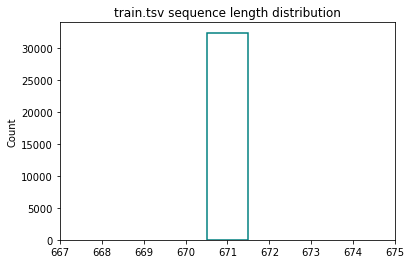

In [451]:
mean_val=np.mean(train["sequence"].str.len())
p=sns.histplot(list(train["sequence"].str.len()), color="teal", fill=False)
p.set_xlim([mean_val-4, mean_val+4])
p.set_title("train.tsv sequence length distribution")
plt.show()

Why it's all 671? Maybe it is because they are for DNABERT-PROM, which is the 300 bp around the TSS. <br>
Because the length of the k-merized sequence `L_k` for the originally N-long sequence `L_N`:
>  `L_k = k*(N-k+1)+(N-k)`

Therefore, `671 = 6*(N-6+1)+(N-6)`, which produces N=101.. Why only 101? ...

In [444]:
a="A"*101
len(a)

101

In [445]:
k=6
len(seq2kmer(a,k))

671

In [446]:
k*(len(a)-k+1)+(len(a)-k)==len(seq2kmer(a,k))

True

In [448]:
train["sequence"].iloc[0]

'CACAGC ACAGCC CAGCCA AGCCAG GCCAGC CCAGCC CAGCCA AGCCAC GCCACT CCACTA CACTAG ACTAGG CTAGGC TAGGCC AGGCCC GGCCCT GCCCTG CCCTGT CCTGTC CTGTCC TGTCCT GTCCTG TCCTGC CCTGCA CTGCAG TGCAGC GCAGCC CAGCCC AGCCCC GCCCCC CCCCCT CCCCTG CCCTGT CCTGTA CTGTAG TGTAGG GTAGGG TAGGGG AGGGGT GGGGTC GGGTCT GGTCTG GTCTGG TCTGGA CTGGAA TGGAAC GGAACA GAACAG AACAGC ACAGCC CAGCCA AGCCAG GCCAGG CCAGGA CAGGAG AGGAGT GGAGTG GAGTGG AGTGGT GTGGTT TGGTTT GGTTTA GTTTAA TTTAAG TTAAGA TAAGAG AAGAGG AGAGGC GAGGCA AGGCAG GGCAGG GCAGGG CAGGGG AGGGGA GGGGAG GGGAGT GGAGTC GAGTCG AGTCGC GTCGCC TCGCCT CGCCTT GCCTTG CCTTGC CTTGCC TTGCCC TGCCCT GCCCTG CCCTGT CCTGTG CTGTGC TGTGCC GTGCCA TGCCAC GCCACA CCACAC'

In [449]:
len(train["sequence"].iloc[0])

671

In [450]:
len(kmer2seq(train["sequence"].iloc[0]))

101

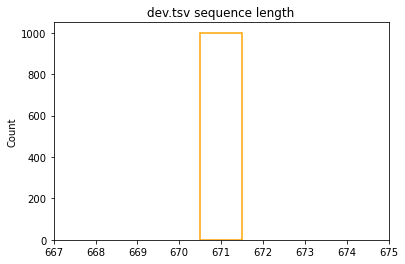

In [452]:
mean_val=np.mean(dev["sequence"].str.len())
p=sns.histplot(list(dev["sequence"].str.len()), color="orange", fill=False)
p.set_xlim([mean_val-4, mean_val+4])
p.set_title("dev.tsv sequence length")
plt.show()

## Load the file we have for genic and intergenic area
* First, test the 2nd chromosome, 4mers
* Path
    * `../database/fine_tune/genic_and_intergenic/4mer/gene` for genes
    * `../database/fine_tune/genic_and_intergenic/4mer/Ngene` for non-genes

### Read chr2 for creating the similar dataset (4mer)

In [386]:
g_file="../database/fine_tune/genic_and_intergenic/4mer/gene/chr2_gene.txt"
ng_file="../database/fine_tune/genic_and_intergenic/4mer/Ngene/chr2_Ngene.txt"

In [393]:
g_chr2_4mer_css=pd.read_csv(g_file, header=None, names=["sequence"], sep="\n")
ng_chr2_4mer_css=pd.read_csv(ng_file, header=None, names=["sequence"], sep="\n")

In [394]:
g_chr2_4mer_css["label"]=1
ng_chr2_4mer_css["label"]=0

In [395]:
g_chr2_4mer_css.head()

,sequence,label
0,FFFE FFEE FEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,1
1,EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,1
2,EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,1
3,EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,1
4,EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE E...,1


In [415]:
max(g_chr2_4mer_css["sequence"].str.len())

2534

In [453]:
g_chr2_4mer_elm_len=list(g_chr2_4mer_css["sequence"].str.len())

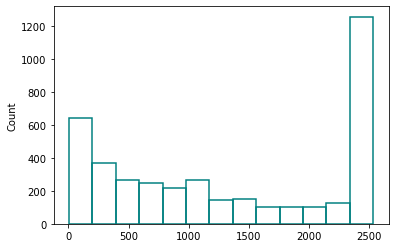

In [461]:
p_g=sns.histplot(g_chr2_4mer_elm_len, color="teal", fill=False) # must be similar to our random cut.

In [398]:
print("gene file length: ", len(g_chr2_4mer_css))

gene file length:  3991


In [399]:
ng_chr2_4mer_css.head()

,sequence,label
0,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
1,AAAA AAAA AAAN AANN ANNN NNNN NNNN NNNN NNNN N...,0
2,OOOO OOOG OOGE OGEE GEEE EEEE EEEE EEEE EEEE E...,0
3,NNNN NNNN NNNJ NNJJ NJJA JJAA JAAO AAOO AOOO O...,0
4,NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNM N...,0


In [400]:
print("none-gene file length: ", len(ng_chr2_4mer_css))

none-gene file length:  1781


In [456]:
ng_chr2_4mer_elm_len=list(ng_chr2_4mer_css["sequence"].str.len())

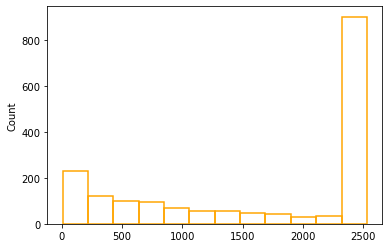

In [460]:
p_ng=sns.histplot(ng_chr2_4mer_elm_len, color="orange", fill=False) 

Okay, then because pre-train is trained with such condition, I will stick with this concept. <br>
One thing we need is to do is combining them into one tsv files (50:50). <br>

To do this,
1. Combine multiple chr (chosen randomly? or all?) ... let's start with the whole. If it's too large, then go random
2. Label the gene's segments with 1, while Ngene with 0.
3. Make it half-half
4. Determine the size for train and dev
5. Save it as tsv file

In [658]:
# preparing the dataframe-version for generating train and dev dataset
def prepFT_gNg(path="../database/fine_tune/genic_and_intergenic/", k=4, sampling_no=10):
    dir_k=path+str(k)+"mer/"
    
    dir_g=dir_k+"gene/"
    dir_ng=dir_k+"Ngene/"
    g_files=os.listdir(dir_g)
    ng_files=os.listdir(dir_ng)
    all_g_files=file_list_maker(dir_g,g_files)
    all_ng_files=file_list_maker(dir_ng,ng_files)
    
    g_len_all,ng_len_all=[],[]
    df_ng_all,df_g_all=[],[]
    
    ### for Ngene data
    for chr_ng in all_ng_files:
        df_ng=pd.read_csv(chr_ng, header=None, names=["sequence"], sep="\n")
        df_ng["label"]=0        
        ng_len=len(df_ng)  # only for checking length
        ng_len_all.append(ng_len)  # only for checking length
        
        df_ng_all.append(df_ng) 
    df_ng_concat=pd.concat(df_ng_all)  # for ng, concatenate all the list
    
    ### for gene data
    sample=random.sample([i for i, elm in enumerate(all_g_files)], sampling_no)
    print("Sampled chromosome for genic region: {}".format(sample))
    for i, chr_g in enumerate(all_g_files):
        df_g=pd.read_csv(chr_g, header=None, names=["sequence"], sep="\n")
        df_g["label"]=1
        g_len=len(df_g)  # only for checking length
        g_len_all.append(g_len)  # only for checking length
        
        if i in sample:   # sampling 
            df_g_all.append(df_g)
        else:
            continue
    df_g_concat=pd.concat(df_g_all)
    
    ### for the length adjustment ###
    if len(df_g_concat)>len(df_ng_concat):
        df_g_concat=df_g_concat[:len(df_ng_concat)] 
    elif len(df_g_concat)<len(df_ng_concat):
        df_ng_concat=df_ng_concat[:len(df_g_concat)]
    assert len(df_g_concat)==len(df_ng_concat)
    
    df_g_ng_all=pd.concat([df_ng_concat,df_g_concat]).sample(frac=1).reset_index(drop=True)  # shuffling    
    
    ### for visualization purpose ###
#     fig, ax = plt.subplots(1,1,figsize=(6,4))
#     ax=sns.histplot(g_len_all, color="teal", element="step", bins=10, fill=False) #cumulative=True
#     ax=sns.histplot(ng_len_all, color="orange", element="step", bins=4, fill=False)
#     plt.title("Cumulative plot of genic/intergenic data size", fontsize=13)
#     ax.set_xlabel("Length of data", fontsize=13)
#     ax.legend(["genic","intergenic"])
#     plt.show()   
        
    return df_g_ng_all

In [659]:
df_g_ng_all=prepFT_gNg("../database/fine_tune/genic_and_intergenic/", k=4, sampling_no=10)

Sampled chromosome for genic region: [11, 15, 6, 13, 20, 9, 2, 3, 0, 4]


In [662]:
len(df_g_ng_all)

47904

In [681]:
def saveTF_gNg(df_g_ng_all, path="../database/fine_tune/genic_and_intergenic/",k=4,len_train=30000,len_dev=1000):
    dir_k=path+str(k)+"mer/"
    df_g_ng_train=df_g_ng_all[:len_train]
    df_g_ng_dev=df_g_ng_all[len_train:len_train+len_dev]    
    
    train_name=dir_k+"train.tsv"
    dev_name=dir_k+"dev.tsv"
    
    df_g_ng_train.to_csv(train_name, sep="\t", index=False)
    df_g_ng_dev.to_csv(dev_name, sep="\t", index=False)
    
    return print("train.tsv and dev.tsv Files are saved at '{}'.". format(dir_k))

In [682]:
len(df_g_ng_all)

47904

In [683]:
saveTF_gNg(df_g_ng_all, path="../database/fine_tune/genic_and_intergenic/",k=4,len_train=30000,len_dev=1000)

train.tsv and dev.tsv Files are saved at '../database/fine_tune/genic_and_intergenic/4mer/'.


In [17]:
check_file1=pd.read_csv("../database/fine_tune/genic_and_intergenic/4mer/train.tsv", sep="\t")
check_file2=pd.read_csv("../database/fine_tune/genic_and_intergenic/4mer/dev.tsv", sep="\t")

In [19]:
print("len(train.tsv): ", len(check_file1))
print("len(dev.tsv): ", len(check_file2))

len(train.tsv):  30000
len(dev.tsv):  1000


In [672]:
df_g_ng_all[3:5].to_csv("../database/test.tsv", sep="\t", index=False)

In [673]:
# check 
check=pd.read_csv("../database/test.tsv", sep="\t")
check.head()

,sequence,label
0,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0
1,OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO O...,0


In [6]:
chr2_path=np.sort(all_files)[1]
chr2_path

'../database/bed/unzipped/E002_15_coreMarks_stateno.bed'

In [7]:
df=bed2df_expanded(chr2_path)

In [9]:
all_unit_css=df2unitcss(df)

In [10]:
len(all_unit_css[1])

1215996

In [8]:
with open("../database/temp_files/css_gene_lst_all", "rb") as f:
    css_gene_lst_all=pickle.load(f) # genic area only

In [12]:
len(css_gene_lst_all[0])

5255

In [13]:
len(css_gene_lst_all[0][5000])

97262

In [14]:
# length distribution first!
# then the non-genic region!

In [15]:
def flatLst(lst):
        flatten_lst=[elm for sublst in lst for elm in sublst]
        return flatten_lst

In [16]:
flatten_css_gene_lst=flatLst(css_gene_lst_all)
len(flatten_css_gene_lst)

52260

In [17]:
def len_css_gene(css_gene_lst_all,color="teal"):
    def flatLst(lst):
        flatten_lst=[elm for sublst in lst for elm in sublst]
        return flatten_lst
    flatten_css_gene_lst=flatLst(css_gene_lst_all)
#     fig=plt.figure(figsize=(6,4))    
#     plt.hist(flatten_css_gene_lst)
# #     sns.histplot(flatten_css_gene_lst, kde=False, color=color, log_scale=True, element="step", fill=False)
# #     sns.histplot(flatten_css_gene_lst, kde=False, color=color, log_scale=True)
#     plt.xlabel("Length of each element in dataset", fontsize=12)
#     plt.show()
    return flatten_css_gene_lst

In [18]:
flatten_css_gene_lst=len_css_gene(css_gene_lst_all)

In [19]:
len(flatten_css_gene_lst)

52260

In [20]:
# plt.hist(flatten_css_gene_lst)  ## too large? kernel dies everytime I run this

In [380]:
g_df_chr_lst=whGene2GLChr(whole_gene_file)

In [388]:
max(g_df_chr_lst[0]["TxEnd"])

249213345

# Start here, now we got the new gene list

In [3]:
whole_gene_file

'../database/RefSeq/RefSeq.WholeGene.bed'

In [4]:
new_gene_lst_all=gene_removeDupl(whole_gene_file)

Extracting the gene file ...
Done!


In [5]:
len(new_gene_lst_all)

24

In [14]:
new_gene_lst_all[23].head(10)

,TxStart,TxEnd
0,142990,170022
1,171416,180887
2,231384,232054
3,244667,297690
4,535078,570146
5,1264893,1281616
6,1337692,1378828
7,1405508,1451582
8,1455044,1461039
9,1465917,1468291


In [397]:
def compNonGene2css(whole_gene_file,df):
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at "non-genic" area only.
    """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome

    print("Extracting the CSS on the intergenic region ...")

    ########### new fancy gene table without overlap ###########
    new_gene_lst_all=gene_removeDupl(whole_gene_file)
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(new_gene_lst_all)
    
    css_Ngene_lst_all=[]
        
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=new_gene_lst_all[i] # gene df of i-th chromosome
        
        assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
        assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
        css_Ngene_lst_chr=[]        
        for j in range(len(gene_df)):
            if j==0:
                ng_start=1 # to avoid any "zero" causing problem 
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            elif j==len(gene_df)-1: 
                ng_start=gene_df["TxEnd"].iloc[j]
                ng_end=len(css)
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            else:
                ng_start=gene_df["TxEnd"].iloc[j-1]
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking 
        
            css_Ngene=css[ng_start:ng_end]
            css_Ngene_lst_chr.append(css_Ngene)
        
        css_Ngene_lst_all.append(css_Ngene_lst_chr)  
    
    assert len(css_Ngene_lst_all)==total_chr
    print("Done!")
    
    return css_Ngene_lst_all

In [398]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)

Extracting the CSS on the intergenic region ...



Done!


In [399]:
len(css_Ngene_lst_all[0])  # ... but shouldn't be this to be 2188+1?? (so that the initial, final sections are added)

2188

In [ ]:
# Okay, we now have genic, and non-genic area css. Now what? 
# Fine tuning for the dnabert was for 300 bp promoter finding, but our case is different.
# First, I will go with the random cut (5-512) as we did in the pre-training
## first, let us check the length distribution

In [597]:
len(css_Ngene_lst_all[0])

2188

In [593]:
with open ("../database/temp_files/css_gene_lst_all", "rb") as f:
    css_gene_lst_all=pickle.load(f)

In [10]:
with open ("../database/temp_files/css_Ngene_lst_all", "rb") as g:
    css_Ngene_lst_all=pickle.load(g)

In [11]:
len(css_gene_lst_all)

24

In [12]:
len(css_Ngene_lst_all[0])

2188

In [99]:
def countGeneCss(css_gene_lst_all):
    g_css_cnt_all=[]
    g_css_len_all=[]
    tot_chr=len(css_gene_lst_all)
    for chr_no in range(tot_chr):
        g_chr_lst=css_gene_lst_all[chr_no]
        g_css_cnt_all.append(len(g_chr_lst))
        g_css_len_chr=[]
        for i in range(len(g_chr_lst)):
            g_css_len=len(g_chr_lst[i])
            g_css_len_chr.append(g_css_len)  # to let it iterate for chr!
        g_css_len_all.append(g_css_len_chr)
    g_css_len_all=flatLst(g_css_len_all) 
    
    g_css_len_all=list(filter(lambda elm: elm!=0, g_css_len_all))  # remove 0s
        
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    fig,(ax1, ax2)=plt.subplots(1,2,figsize=(12,4), sharey=False)
    ax1=sns.histplot(g_css_cnt_all, bins=12, color="cadetblue", element="step", fill=False, ax=ax1)
    ax1.set_xlabel("Count of data strip on Genic region", fontsize=13)
    ax1.set_ylabel("Count", fontsize=13)
    ax1.grid(b=None)
    ax1.xaxis.grid(None)
    ax1.yaxis.grid()
    
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    ax2=sns.histplot(g_css_len_all, bins=15, log_scale=True, color="crimson", element="step", fill=False, ax=ax2)
    ax2.set_xlabel("Length of CSS on Genic region", fontsize=13)
    ax2.set_ylabel("Count", fontsize=13)
    ax2.grid(b=None)
    plt.grid(False)
            
    return g_css_cnt_all,g_css_len_all

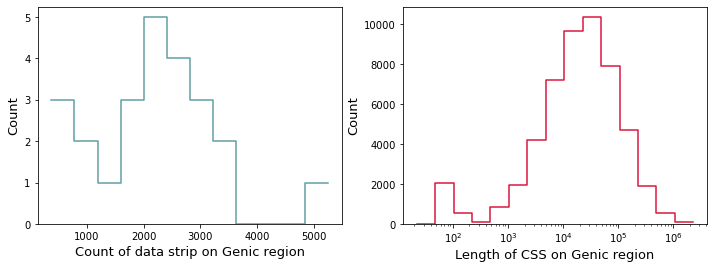

In [100]:
g_css_cnt_all,g_css_len_all=countGeneCss(css_gene_lst_all)

In [584]:
with open ("../database/temp_files/css_Ngene_lst_all", "wb") as f:
    pickle.dump(css_Ngene_lst_all, f)

In [96]:
def countNgeneCss(css_Ngene_lst_all):
    ng_css_cnt_all=[]
    ng_css_len_all=[]
    tot_chr=len(css_Ngene_lst_all)
    for chr_no in range(tot_chr):
        ng_chr_lst=css_Ngene_lst_all[chr_no]
        ng_css_cnt_all.append(len(ng_chr_lst))
        ng_css_len_chr=[]
        for i in range(len(ng_chr_lst)):
            ng_css_len=len(ng_chr_lst[i])
            ng_css_len_chr.append(ng_css_len)  # to let it iterate for chr!
        ng_css_len_all.append(ng_css_len_chr)
    ng_css_len_all=flatLst(ng_css_len_all) 
    
    ng_css_len_all=list(filter(lambda elm: elm!=0, ng_css_len_all))  # remove 0s
        
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    fig,(ax1, ax2)=plt.subplots(1,2,figsize=(12,4), sharey=False)
    ax1=sns.histplot(ng_css_cnt_all, bins=12, color="navy", element="step", fill=False, ax=ax1)
    ax1.set_xlabel("Count of data strip on Intergenic region", fontsize=13)
    ax1.set_ylabel("Count", fontsize=13)
    ax1.grid(b=None)
    ax1.xaxis.grid(None)
    ax1.yaxis.grid()
    
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    ax2=sns.histplot(ng_css_len_all, bins=15, log_scale=True, color="maroon", element="step", fill=False, ax=ax2)
    ax2.set_xlabel("Length of CSS on Intergenic region", fontsize=13)
    ax2.set_ylabel("Count", fontsize=13)
    ax2.grid(b=None)
    plt.grid(False)
            
    return ng_css_cnt_all,ng_css_len_all

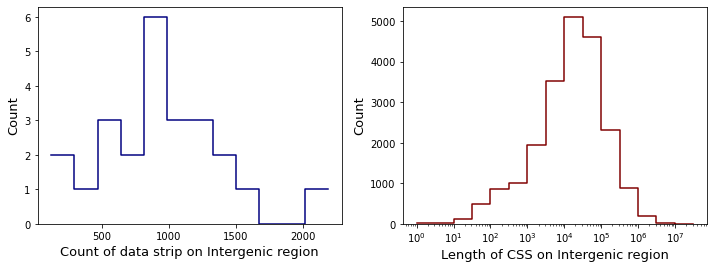

In [97]:
ng_css_cnt_all,ng_css_len_all=countNgeneCss(css_Ngene_lst_all)

In [ ]:
# randomly cut the string for fine tuning

def css4FineTune_ranCUT_Kmer(css_lst, genic=True, chr_no=2,num1=5,num2=510, k=3, weight_rn=False, v_name="v1.01"):
    """
    Usage: css4FineTune_ranCUT_Kmer(df,num1,num2, k, weight_rn, v_name)
    
    - css_lst: Either css_gene_lst_all or css_Ngene_lst_all
    - genic: True if css_gene_lst_all, False if css_Ngene_lst_all
    - chr_no: no. of chromosome
    - num1: cut range start
    - num2: cut range end
    - weight_rn: 
      if True: random with weighted, 50% of chance to be num2, 50% random between num1 and num2
      if False: random between num1 and num2
    - k: kmer
    - v_name: version name to be used as a file name 
      (Conventionally, 01 was used for weighted_rn False, 02 for True
       v1 just stands for telomere is set to be 50 unit)
    
    output: randomly cut w15 css for one chromosome for fine tuning data.
    """
    
    css_lst_chr=css_lst[chr_no]  # only for one chromosome 
    
    if genic:
        css_lst_chr_wotelo=css_lst_chr
    else:
        css_lst_chr_wotelo=css_lst_chr[50:-50] #cut the telomere when intergenic (because they contain telo)

    splitted=[]
    prev=0

    ori_lst=[elm for elm in range(num1,num2+1)]   # list of num between num1 and num2
    sin_lst=[num2]*len(ori_lst)   # list of all num2 (length is the same of ori_lst)
    tot_lst=ori_lst+sin_lst
    
    while True:
        
        if weight_rn:
            n=random.choice(tot_lst)

        else:
            n=random.randint(num1,num2)
        
        splitted.append(ch1_unit_css_wotelo[prev:prev+n])
        prev=prev+n
        if prev >= len(ch1_unit_css_wotelo)-1:
            break
   
    ch1_unit_css_wotelo_kmer=[seq2kmer(item, k) for item in splitted]
    
      
    path='../database/fine_tune/'
    fn_base="chr"+str(chr_no)+"_"+str(k)+v_name   # version 1.01_pre (Oct. 2022) : telo 50 unit, rn 200-1000
                                                              # version 1.01 (Oct. 2022) : telo 50, rn 5 - 510
    ext=".txt"
          
    fn=path+fn_base+ext  # file name

    with open(fn,"w") as save_file:
        save_file.write("\n".join(ch1_unit_css_wotelo_kmer))
          
    return print("unit-length css of chr{} cut randomly(weighted range:{}-{}) for {}mer was saved at {}".format(chr_no, num1, num2, k,fn))

In [16]:
len(css_gene_lst_all)

24

In [637]:
a=['AAAAABBBBBCCCCC','AAAAABBBBB']

In [638]:
for i in a:
    

['AAAAABBBBBCCCCC', 'AAAAABBBBB']

In [656]:
unit_lst=[]
unit_bp=5
for elm in a:   
    let_set=list(set(elm))
    unit_elm=''
    print(elm)
    for uniq in let_set:
        uniq_cnt=elm.count(uniq)
        print(uniq, uniq_cnt)
        unit_elm+=uniq*int((uniq_cnt)/unit_bp)
    unit_lst.append(unit_elm)
    assert int(len(elm))==int(len(unit_elm)*unit_bp)

AAAAABBBBBCCCCC
A 5
B 5
C 5
AAAAABBBBB
A 5
B 5


In [ ]:
# def long2unitCSS(long_css, unit_bp=200):
#     """
#     * description *
#     long_css is the result of the function "df2longcss" (real length css), 
#     and this function aims to convert it into the result of the "function df2unitcss",
#     which is shortest possible version of the css.
#     Why? because pre-train data for ChromBERT is done by unit-length, 
#     and the genic/intergenic css is acquired as a long-css
#     """
#     unit_lst_all=[]
#     for chr_no in long_css:
#         long_css_chr=long_css[chr_no]   # chromosome-wise    
#         unit_lst=[]
#         for elm in long_css_chr:   
#             let_set=list(set(elm))  # unique characters  ########## NOOOOOO, it cannot be done like this, because there can be repetitive pattern.
            
#             unit_elm=''
# #             print(elm)
#             for uniq in let_set:
#                 uniq_cnt=elm.count(uniq)
# #                 print(uniq, uniq_cnt)
#                 unit_elm+=uniq*int((uniq_cnt)/unit_bp)
#             unit_lst.append(unit_elm)
#             assert int(len(elm))==int(len(unit_elm)*unit_bp)
            
#         unit_lst_all.append(unit_lst)
            

In [806]:
a=['AAAAABBBBBCCCCCAAAAACCCCC','DDDDDEEEEEAAAAABBBBBAAAAABBBBB']

In [807]:
a

['AAAAABBBBBCCCCCAAAAACCCCC', 'DDDDDEEEEEAAAAABBBBBAAAAABBBBB']

In [809]:
unit_cnt_lst_all=[]
for elm in a:
    unit_cnt_lst=[]
    unit_cnt=0
    for i, ch in enumerate(elm):
        if i==0:
            unit_cnt=1 
        elif i==len(elm)-1: # last letter
            unit_cnt+=1
            unit_cnt_lst.append(unit_cnt)
        elif ch==elm[i-1]:            
            unit_cnt+=1        
        elif (ch!=elm[i-1] and i!=len(elm)-1):
            unit_cnt_lst.append(unit_cnt)
            unit_cnt=1
        else:
            continue
    unit_cnt_lst_all.append(unit_cnt_lst)

unit_cnt_lst_all

[[5, 5, 5, 5, 5], [5, 5, 5, 5, 5, 5]]

In [797]:
unit_cnt_lst

[5, 5, 5, 5]

In [21]:
# the idea is to separate, count, combine
def long2unitCSS(long_css_lst, unit=200):
    """
    * description *
    long_css is the result of the function "df2longcss" (real length css), 
    and this function aims to convert it into the result of the function "df2unitcss",
    which is shortest possible version of the css.
    Why? because pre-train data for ChromBERT is done by unit-length, 
    and the genic/intergenic css is acquired as a long-css
    
    Input: long_css_lst (type=list) acquired by df2longcss(df) and the unit length bp (default=200 bp)
    Output: let_str_lst_all (list of unit state) and unit_cnt_lst_all (list of list)
    """
    assert type(long_css_lst)==list, "Check the input type: it should be a list, but now it's {}".format(type(long_css_lst))
    assert type(long_css_lst[0])==str, "Check the type of input element: it should be a string, but it's {}".format(type(long_css_lst[0]))
    let_str_lst_all=[]
    unit_cnt_lst_all=[]
    for elm in long_css_lst:
        unit_str=''
        unit_cnt_lst=[]
        unit_cnt=0
        for i, let_str in enumerate(elm):
            if i==0:     # handling the first letter
                unit_str+=let_str
                unit_cnt=1
            elif i==len(elm)-1:    # handling the final letter
                unit_cnt+=1
                unit_cnt_lst.append(int(unit_cnt/unit)) 
            elif let_str==elm[i-1]:
                unit_cnt+=1      
            elif (let_str!=elm[i-1] and i!=len(elm)-1):
                unit_str+=let_str            
                unit_cnt+=1
                unit_cnt_lst.append(int(unit_cnt/unit))  
                unit_cnt=1
            else:
                continue
        let_str_lst_all.append(unit_str)
        unit_cnt_lst_all.append(unit_cnt_lst)
    return let_str_lst_all, unit_cnt_lst_all

In [122]:
et_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_Ngene_lst_all[0], unit=200)

In [123]:
let_str_lst_all=et_str_lst_all

In [148]:
unit_css_lst=['']*len(let_str_lst_all)
for i, let_str in enumerate(let_str_lst_all):
    for j in range(len(let_str)-1):
        unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
unit_css_lst=[css for css in unit_css_lst if css!='']

In [149]:
len(unit_css_lst)

1412

In [987]:
# def Convert2unitCSS_main(css_lst_all=css_gene_lst_all, unit=200):
#     """
#     Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
#     Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
#     """
#     for chr_no in tqdm_notebook(range(len(css_lst_all))):
#         css_chr_lst=css_lst_all[chr_no]
#         css_chr_unit_lst=[]
#         for css_elm in css_chr_lst:
#             print(type(css_elm))
#             let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_elm, unit=unit)
#             unit_css_lst=['']*len(let_str_lst_all)
#             for i, let_str in enumerate(let_str_lst_all):
#                 for j in range(len(let_str)):
#                     unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j]*unit
#             css_chr_unit_lst.append(unit_css_lst)
#     return css_chr_unit_lst

In [153]:
def Convert2unitCSS_main(css_lst_all=css_gene_lst_all, unit=200):
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    print("Converting css from the raw length into unit-length ... ")
    css_unit_lst_all=[]
    for chr_no in tqdm_notebook(range(len(css_lst_all))):
        css_chr_lst=css_lst_all[chr_no]
        css_chr_unit_lst=[]
        let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_chr_lst, unit=unit)
        unit_css_lst=['']*len(let_str_lst_all)
        for i, let_str in enumerate(let_str_lst_all):
            for j in range(len(let_str)-1):
                unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
        unit_css_lst=[css for css in unit_css_lst if css!='']  # remove the empty element
        css_unit_lst_all.append(unit_css_lst)
    print("Done!")
    return css_unit_lst_all

In [154]:
css_gene_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)

Converting css from the raw length into unit-length ... 



Done!


In [159]:
len(css_gene_unit_lst_all[0][0])

67

In [168]:
css_Ngene_unit_lst_all=Convert2unitCSS_main(css_Ngene_lst_all, unit=200)

Converting css from the raw length into unit-length ... 



Done!


In [169]:
len(css_Ngene_unit_lst_all[0][0])

16

In [ ]:
for css_gene_unit_chr in css_gene_unit_lst_all:
    for 

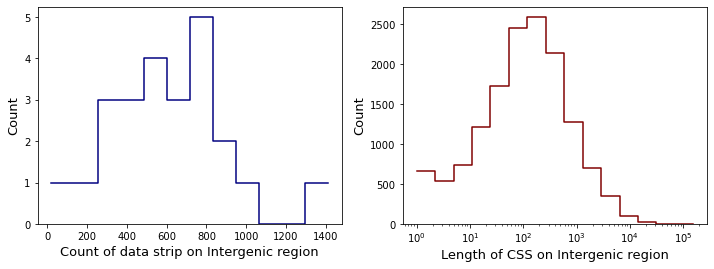

In [170]:
ng_css_cnt_all,ng_css_len_all=countNgeneCss(css_Ngene_unit_lst_all)

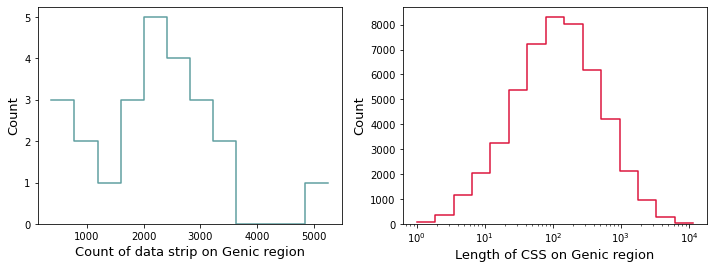

In [101]:
g_css_cnt_all,g_css_len_all=countGeneCss(css_gene_unit_lst_all) ### save css_gene_unit_lst_all!

In [171]:
with open("../database/temp_files/css_gene_unit_lst_all","wb") as f:
    pickle.dump(css_gene_unit_lst_all,f)

In [172]:
with open("../database/temp_files/css_Ngene_unit_lst_all","wb") as f:
    pickle.dump(css_Ngene_unit_lst_all,f)

In [333]:
# Cut the unit-length string (input: unit-css, not df)
def chr_css_CUT_Kmer(unit_css, chr_no, cut_thres, k):
    """    
    Prepare kmer dataset for unit_css, as is if length<=510, else cut it to be length>510   
    Usage: chr_css_CUT_Kmer(unit_css, chr_no, cut_thres, k)
    
    - unit_css: list of chromosome-wise list of unit-length css (e.g. css_gene_unit_lst_all)
    - chr_no: no. of chromosome
    - cut_thres: length of split, default=510
    - k: kmer
    
    Output: 1. splitted (before kmerization) 2. kmerized_unit_css (after kmerization) 
    """    
    chr_unit_css=unit_css[chr_no]   # designated chromosome no.    
    splitted=[] # bucket for the all the splitted strings   
    cnt_short, cnt_long=0,0
    for css_elm in chr_unit_css:
        if len(css_elm) <=cut_thres:
            splitted.append(css_elm)
            cnt_short+=1
        else:
            cnt_long+=1
            prev=0
            while True:
                splitted.append(css_elm[prev:prev+cut_thres])
                prev+=cut_thres
                if prev>=len(css_elm)-1:
                    break                   
    kmerized_unit_css=[seq2kmer(item, k) for item in splitted]
    long_pro=cnt_long/(cnt_long+cnt_short)
    
    return splitted, kmerized_unit_css

In [316]:
g_splitted, g_kmerized_unit_css=chr_css_CUT_Kmer(css_gene_unit_lst_all,2, 510, 3)

In [317]:
with open("../database/fine_tune/genic_and_intergenic/3mer/chr2_gene.txt", "w") as f:
    f.write("\n".join(kmerized_unit_css))

In [325]:
len_g_splitted=[len(elm) for elm in g_splitted]

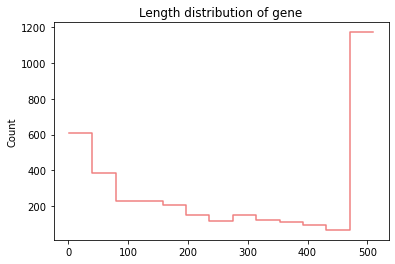

In [326]:
p=sns.histplot(len_g_splitted, element='step', fill=False, color="lightcoral")
p.set_title("Length distribution of gene")
plt.show()

In [358]:
def saveCUTs_all(unit_css, cut_thres, k, gene=True):
    for chr_no in range(len(unit_css)):        
        _, kmerized=chr_css_CUT_Kmer(unit_css, chr_no, cut_thres, k)
        chr_num=str(chr_no+1)
        if gene:
            g='gene'
        else:
            g='Ngene'
   
        path="../database/fine_tune/genic_and_intergenic/"
        kmer=str(k)+'mer/'
        folder=g+"/"
        name="chr"+chr_num+"_"+g+".txt"
        f_name=path+kmer+folder+name
        
        with open(f_name, "w") as f:
            f.write("\n".join(kmerized))
    return #print("{}merized files for {} are saved at {}.".format(k,unit_css,path+kmer))

In [356]:
saveCUTs_all(css_Ngene_unit_lst_all, 510, 3, gene=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [357]:
saveCUTs_all(css_gene_unit_lst_all, 510, 3, gene=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [359]:
saveCUTs_all(css_gene_unit_lst_all, 510, 4, gene=True)

In [360]:
saveCUTs_all(css_Ngene_unit_lst_all, 510, 4, gene=False)

In [331]:
len(css_Ngene_unit_lst_all)

24

In [328]:
n_splitted, n_kmerized_unit_css=chr_css_CUT_Kmer(css_Ngene_unit_lst_all, 2, 510, 3)

In [329]:
n_len_splitted=[len(elm) for elm in n_splitted]

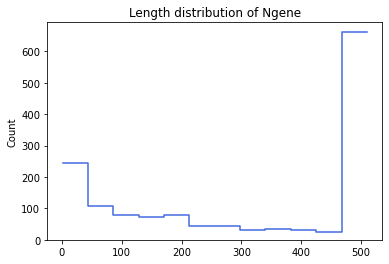

In [330]:
np=sns.histplot(n_len_splitted, element='step', fill=False, color="royalblue")
np.set_title("Length distribution of Ngene")
plt.show()

In [300]:
with open("../database/fine_tune/genic_and_intergenic/3mer/chr2_Ngene.txt", "w") as f:
    f.write("\n".join(kmerized_unit_css))

In [269]:
cnt_short_all

643

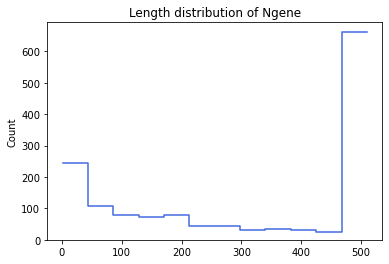

In [312]:
p=sns.histplot(len_splitted, element='step', fill=False, color="royalblue")
p.set_title("Length distribution of Ngene")
plt.show()

In [28]:
def check_main(css_lst_all, unit):

    css_chr_lst=css_lst_all
    check_css_chr_unit_lst=[]

    let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_chr_lst, unit=unit)
    
    unit_css_lst=['']*len(let_str_lst_all)
    
    for i, let_str in enumerate(let_str_lst_all):
        for j in range(len(let_str)):
            unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
#         print(i,j,unit_css_lst)
    
    return unit_css_lst  # not append, just as-is!

In [376]:
# #### backup

# def compNonGene2css(whole_gene_file,df):
#     """
#     Input: Reference gene file, df (CSS)
#     Output: list of chromosome-wise list that contains the css at "non-genic" area only.
#     """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
#     css_lst_chr=df2longcss(df) # list of long css per chromosome
#     total_chr=len(g_lst_chr)
    
#     css_Ngene_lst_all=[]
#     for i in tqdm_notebook(range(total_chr)):
#         css=css_lst_chr[i]   # long css of i-th chromosome
#         gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
#         assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
#         assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
#         css_Ngene_lst_chr=[]
#         for j in range(len(gene_df)):
#             if j==0:
#                 ng_start=1 # to avoid any "zero" causing problem 
#                 ng_end=gene_df["TxStart"].iloc[j]
# #                 css_gene=css[g_start:g_end] 
#             elif j==len(gene_df)-1: 
#                 ng_start=gene_df["TxEnd"].iloc[j]
#                 ng_end=len(css)-1
#             else:
#                 ng_start=gene_df["TxEnd"].iloc[j-1]
#                 if j <=3:
#                     print("j: {} | ng_start: {}".format(j, ng_start))
#                 ng_end=gene_df["TxStart"].iloc[j]
#                 if j <=3:
#                     print("j: {} | ng_end: {}".format(j, ng_end))
        
#             css_Ngene=css[ng_start:ng_end]
#             css_Ngene_lst_chr.append(css_Ngene)
        
#         css_Ngene_lst_all.append(css_Ngene_lst_chr)   
#     assert len(css_Ngene_lst_all)==total_chr
#     return css_Ngene_lst_all

In [33]:
############ Oh,,, genes are overlapped! I need to make a gene table not to overlap.. to show the non-genic (intergenic)


In [88]:
# function to visualize how many genes are sharing the start and end position on genome

def count_samePos(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    cnt_same_start_all=[]
    pro_same_start_all=[]
    cnt_same_end_all=[]
    pro_same_end_all=[]
    tot_chr_no=len(g_df_chr_lst)
    
    ########### count the same start position ###########
    def count_sameStart(g_df_chr_lst,chr_no):
        cnt_same_start=0
        tot_start=len(g_df_chr_lst[chr_no])
        for i in range(len(g_df_chr_lst[chr_no])):
            chr1=g_df_chr_lst[chr_no]["TxStart"]
            if i==0:
                continue
            elif chr1.iloc[i]==chr1.iloc[i-1]:
                cnt_same_start+=1  # how many same start in rows
            else:
                continue
        prop_same_start=cnt_same_start/tot_start
        return cnt_same_start, prop_same_start
    
    ########### count the same end position ############
    def count_sameEnd(g_df_chr_lst,chr_no):
        cnt_same_end=0
        tot_end=len(g_df_chr_lst[chr_no])
        for i in range(len(g_df_chr_lst[chr_no])):
            chr1=g_df_chr_lst[chr_no]["TxEnd"]       
            if i==0:
                continue
            elif chr1.iloc[i]==chr1.iloc[i-1]:
                cnt_same_end+=1  # how many same start in rows
            else:
                continue
        prop_same_end=cnt_same_end/tot_end
        return cnt_same_end, prop_same_end
    ####################################################
    
    for chr_no in tqdm_notebook(range(tot_chr_no)):
        cnt_same_start, prop_same_start = count_sameStart(g_df_chr_lst,chr_no)
        cnt_same_end, prop_same_end = count_sameEnd(g_df_chr_lst,chr_no)
        
        cnt_same_start_all.append(cnt_same_start)
        pro_same_start_all.append(prop_same_start)
        cnt_same_end_all.append(cnt_same_end)
        pro_same_end_all.append(prop_same_end)
        
    dict_cnt={"cnt_same_start":cnt_same_start_all, "cnt_same_end":cnt_same_end_all}
    dict_pro={"pro_same_start":pro_same_start_all, "pro_same_end":pro_same_end_all}
    df_cnt=pd.DataFrame(dict_cnt)
    df_pro=pd.DataFrame(dict_pro)
    
    ###### Visualization ######
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5), sharey=False)
    ax1=sns.violinplot(data=df_cnt, palette="pastel", linewidth=0.7, saturation=0.5, ax=ax1)
    ax1.set_ylabel("Count", fontsize=15)
    ax2=sns.violinplot(data=df_pro, palette="husl", linewidth=0.7, saturation=0.5, ax=ax2)
    ax2.set_ylim([0.2,0.8])
    ax2.set_ylabel("Proportion", fontsize=15)
    plt.show()

    return df_cnt, df_pro

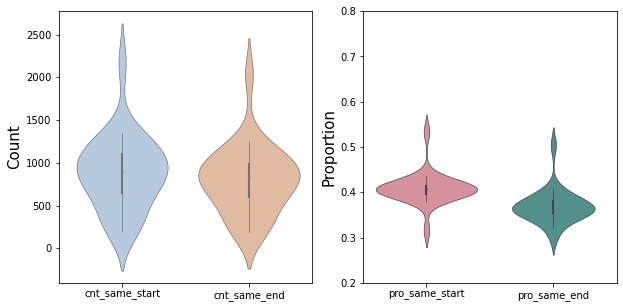

In [89]:
df_cnt, df_pro=count_samePos(whole_gene_file)

In [ ]:
# Now, plan to properly collapse the gene_df.iloc

In [91]:
gene_df.iloc[:100]

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,14409,NR_046018
1460,chr1,14361,29370,NR_024540
1458,chr1,17368,17436,NR_106918
1455,chr1,17368,17436,NR_128720
1457,chr1,17368,17436,NR_107062
...,...,...,...,...
1548,chr1,1334909,1337426,NR_015434
1547,chr1,1337275,1342693,NM_017971
1544,chr1,1353799,1356824,NM_001145210
1545,chr1,1353799,1356824,NM_001243536


In [95]:
# test using this strip
test_df=gene_df[["chromosome","TxStart","TxEnd"]].iloc[:100]

In [96]:
test_df["TxStart"].iloc[0]

11873

In [110]:
len(test_df)

100

In [150]:
len(g_df_chr_lst[0])

5255

In [337]:
def removeOverlapDF(test_df):    
    new_lst=[]
    for i in range(len(test_df)):
        start=test_df["TxStart"].iloc[i]
        end=test_df["TxEnd"].iloc[i]

        exist_pair=(start,end)

        if i==0:
            new_pair=exist_pair
            new_lst.append(new_pair)        
        else:
            start_pre=test_df["TxStart"].iloc[i-1]
            end_pre=test_df["TxEnd"].iloc[i-1]

            # first, concatenate all the shared start
            if start==start_pre:
                new_end=max(end, end_pre)
                new_pair=(start, new_end)
            # second, concatenate all the shared end
            elif end==end_pre:
                new_start=min(start, start_pre)
                new_pair=(new_start, end)
            else:    
                new_pair=exist_pair

        new_lst.append(new_pair) 
    new_lst=list(dict.fromkeys(new_lst))
    
    mod_lst=[[start, end] for (start, end) in new_lst] # as a list element

    for j, elm in enumerate(mod_lst):
        start, end = elm[0], elm[1]

        if j==0:
            continue
        else:
            start_pre=mod_lst[j-1][0]
            end_pre=mod_lst[j-1][1]

            if end_pre>=end:
                mod_lst[j][0]=mod_lst[j-1][0]  # if end_pre is larger than end, replace start as start_pre
                mod_lst[j][1]=mod_lst[j-1][1]  # if end_pre is larger than end, replace end as end_pre

            elif start <=end_pre:
                mod_lst[j][0]=mod_lst[j-1][0]  # current start=start_pre
                mod_lst[j-1][1]=max(mod_lst[j][1],mod_lst[j-1][1])  # end_pre = end

            else:
                continue
           
    mod_lst=[tuple(elm) for elm in mod_lst]
    fin_lst=list(dict.fromkeys(mod_lst))
    gene_collapsed_df=pd.DataFrame(fin_lst, columns=["TxStart", "TxEnd"])
 
    return gene_collapsed_df

In [391]:
def gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=[]
    for chr_no in range(len(g_df_chr_lst)):
        gene_df=g_df_chr_lst[chr_no]
        gene_collapsed_df=removeOverlapDF(gene_df)
        new_gene_lst_all.append(gene_collapsed_df)
    return new_gene_lst_all # list of chromosome-wise dataframe for collapsed gene table

In [392]:
new_gene_lst_all= gene_removeDupl(whole_gene_file)

In [394]:
new_lst_all[0]

,TxStart,TxEnd
0,11873,29370
1,30365,30503
2,34610,36081
3,69090,70008
4,134772,140566
...,...,...
2183,249104650,249120154
2184,249120575,249120642
2185,249132376,249143716
2186,249144202,249153315
